# Plot rat position overlayed on the hex maze!

In [2]:
from spyglass_hexmaze.hex_maze_behavior import HexPositionSelection

nwb_file_name = "Toby20250316_.nwb"

# View all position keys so we can grab one
all_valid_keys = HexPositionSelection.get_all_valid_keys(verbose=False)
for key in all_valid_keys:
    if key["nwb_file_name"] == nwb_file_name:
        print(key)

{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'merge_id': UUID('4eeb7432-969b-f856-3cfb-dd4456754ac4')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 1, 'merge_id': UUID('713b3445-c1da-79f1-4b8e-c5760e604d20')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 3, 'merge_id': UUID('0859decd-5062-ee9c-a51f-575538d091f1')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 3, 'merge_id': UUID('3700aa19-2c40-9e11-eac2-18bbf869340b')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 5, 'merge_id': UUID('ee39b273-4d26-bb25-6525-9a156b049d17')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 5, 'merge_id': UUID('3eb15557-bdae-a85f-56cd-4162761f52e6')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 7, 'merge_id': UUID('7ada0de4-a6dc-1d39-8beb-e61c1a81d05c')}
{'nwb_file_name': 'Toby20250316_.nwb', 'epoch': 7, 'merge_id': UUID('73546f6a-c60f-09f3-0c22-c5e44b3259de')}


# Plot a position heatmap by block

Overlayed on the maze config for each block

Show path lengths and reward probabilites

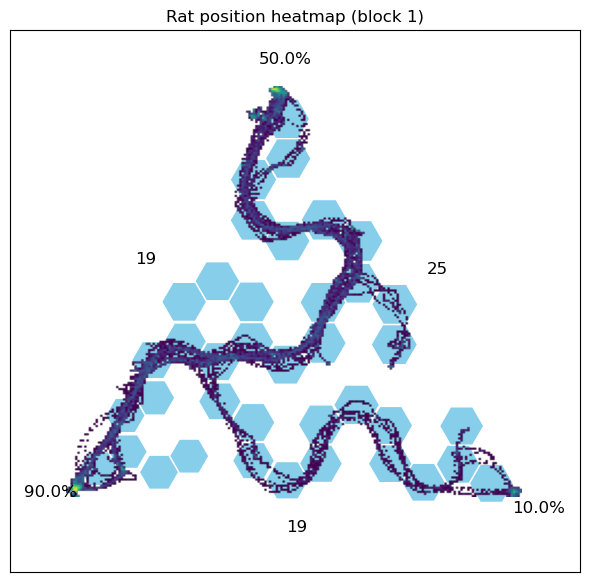

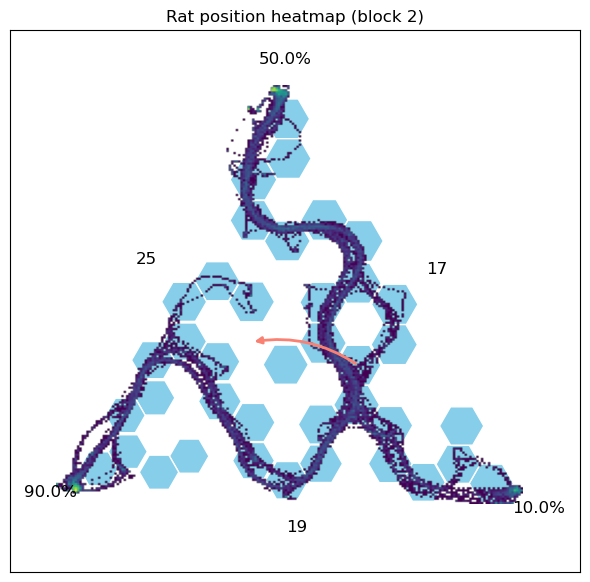

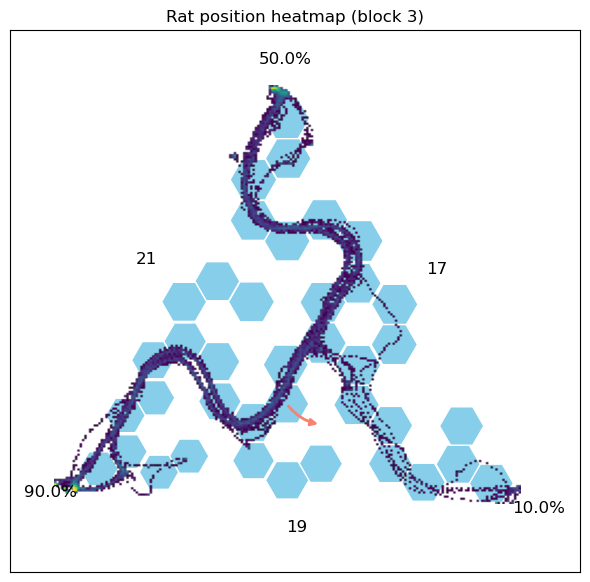

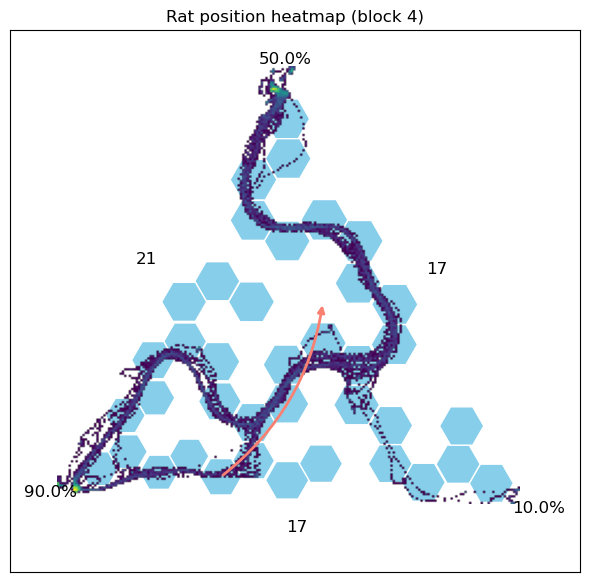

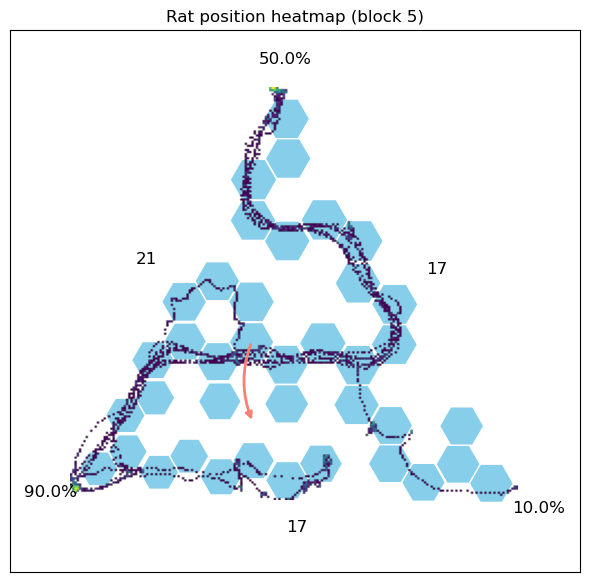

In [7]:
from spyglass.position import PositionOutput
from spyglass.common import IntervalList
from spyglass_hexmaze.hex_maze_behavior import HexMazeBlock, HexCentroids
from hexmaze import plot_hex_maze, get_barrier_changes
import matplotlib.pyplot as plt
import numpy as np

# Grab a key from the output above for now
# Use this merge id to restrict the PositionOutput table and fetch the position data
key = {
    "nwb_file_name": "Toby20250316_.nwb",
    "epoch": 3,
    "merge_id": "0859decd-5062-ee9c-a51f-575538d091f1",
}

# Get block data for this epoch
block_data = HexMazeBlock & {
    "nwb_file_name": key["nwb_file_name"],
    "epoch": key["epoch"],
}

# Fetch processed position data for this epoch
position_df = (PositionOutput & key).fetch1_dataframe()

# Get the hex centroids for this session for plotting the hexes in the right places
centroids_dict = HexCentroids().get_core_hex_centroids_dict_cm(key)

# If this is a barrier change sequence, get the moved barriers
if block_data.fetch("task_type")[0] == "barrier change":
    # Get a list of all maze configs for this block
    barrier_sequence = block_data.fetch("config_id")
    # Find the barriers moved from one configuration to the next so we can add this to our plots
    barrier_changes = get_barrier_changes(barrier_sequence)
else:
    barrier_changes = None

# Loop through all blocks within this epoch
for block in block_data:

    # Get the block start and end times
    block_start, block_end = (
        IntervalList
        & {
            "nwb_file_name": key["nwb_file_name"],
            "interval_list_name": block["interval_list_name"],
        }
    ).fetch1("valid_times")[0]

    # Filter position_df to only include times for this block
    block_mask = (position_df.index >= block_start) & (position_df.index <= block_end)
    block_positions = position_df.loc[block_mask]

    # Get the hex maze config for this block
    maze_config = block.get("config_id")

    # Get reward probs
    reward_probs = [block.get("p_a"), block.get("p_b"), block.get("p_c")]

    # Plot rat position heatmap for this block (currently for session)
    fig_full, ax_full = plt.subplots(figsize=(6, 6))

    # Create 2D histogram (aka heatmap) of the rat's x, y positions in this block
    heatmap_full, xedges, yedges = np.histogram2d(
        block_positions["position_x"].values,
        block_positions["position_y"].values,
        bins=200,
    )
    heatmap_full_masked = np.ma.masked_where(heatmap_full == 0, heatmap_full)
    log_heatmap_full = np.log1p(heatmap_full_masked)

    # If this is a barrier change session (and not the first block), get the newly blocked and newly available hex
    if barrier_changes is not None and block.get("block") != 1:
        old_barrier_hex, new_barrier_hex = barrier_changes[block.get("block") - 2]
    else:
        old_barrier_hex, new_barrier_hex = None, None

    # Plot maze layout (open hexes only) using custom centroids if they exist
    if centroids_dict is not None:
        plot_hex_maze(
            barriers=maze_config,
            centroids=centroids_dict,
            ax=ax_full,
            show_hex_labels=False,
            show_barriers=False,
            show_choice_points=False,
            reward_probabilities=reward_probs,
            invert_yaxis=True,
            old_barrier=old_barrier_hex,
            new_barrier=new_barrier_hex,
            show_arrow=True,
            show_barrier_change=False,
        )
    # Plot rat position heatmap on top of the hexes
    ax_full.imshow(
        log_heatmap_full.T,
        origin="lower",
        cmap="viridis",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect="equal",
        zorder=1,
    )
    ax_full.set_xticks([])
    ax_full.set_yticks([])
    ax_full.set_title(f"Rat position heatmap (block {block.get('block')})")
    fig_full.tight_layout()
    fig_full.show()

# Plot a full session heatmap

Useful for inferring where the rat might have place fields. 

(Don't show maze config or reward probabilities because these change throughout the session)

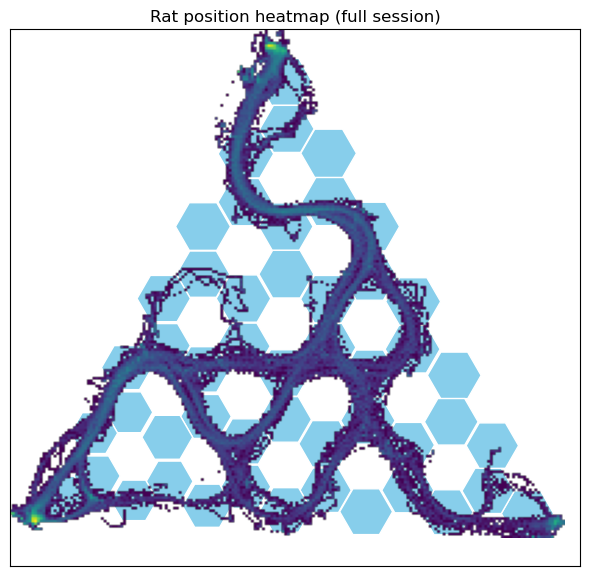

In [ ]:
from spyglass.position import PositionOutput
from spyglass_hexmaze.hex_maze_behavior import HexMazeBlock, HexCentroids
from hexmaze import plot_hex_maze
import matplotlib.pyplot as plt
import numpy as np

# Grab a key from the output above for now
# Use this merge id to restrict the PositionOutput table and fetch the position data
key = {
    "nwb_file_name": "Toby20250316_.nwb",
    "epoch": 3,
    "merge_id": "0859decd-5062-ee9c-a51f-575538d091f1",
}

# Fetch processed position data for this epoch (remove nan)
position_df = (PositionOutput & key).fetch1_dataframe()
position_df = position_df.dropna(subset=["position_x", "position_y"])

# Get the hex centroids for this session for plotting the hexes in the right places
centroids_dict = HexCentroids().get_hex_centroids_dict_cm(key)
# Remove side hex centroids (plotting expects exactly 49 integer centroids)
centroids_dict = {
    int(k): v
    for k, v in centroids_dict.items()
    if "_left" not in k and "_right" not in k
}

# Plot rat position heatmap for the full epoch
fig_full, ax_full = plt.subplots(figsize=(6, 6))

# Create 2D histogram (aka heatmap) of the rat's x, y positions
heatmap_full, xedges, yedges = np.histogram2d(
    position_df["position_x"].values, position_df["position_y"].values, bins=200
)
heatmap_full_masked = np.ma.masked_where(heatmap_full == 0, heatmap_full)
log_heatmap_full = np.log1p(heatmap_full_masked)

# Plot maze layout (open hexes only) using custom centroids if they exist
if centroids_dict is not None:
    plot_hex_maze(
        barriers=None,
        centroids=centroids_dict,
        ax=ax_full,
        show_hex_labels=False,
        show_barriers=False,
        show_choice_points=False,
        invert_yaxis=True,
    )
# Plot rat position heatmap on top of the hexes
ax_full.imshow(
    log_heatmap_full.T,
    origin="lower",
    cmap="viridis",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="equal",
    zorder=1,
)
ax_full.set_xticks([])
ax_full.set_yticks([])
ax_full.set_title(f"Rat position heatmap (full session)")
fig_full.tight_layout()
fig_full.show()